## 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from xgboost import XGBClassifier
# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight


# Imbalance
from imblearn.over_sampling import RandomOverSampler

## 2. Load Dataset

In [2]:
df = pd.read_csv(r"/Users/harikasunkara/Desktop/clinical+genomic_split.csv")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (618, 20)
Columns: ['case_id', 'gender', 'age_diag', 'grade', 'cancer_history', 'ajcc_path_tumor_pt', 'ajcc_path_nodes_pn', 'ajcc_clin_metastasis_cm', 'ajcc_path_metastasis_pm', 'ajcc_path_tumor_stage', 'vital_status_12', 'race_Asian', 'race_Black or African American', 'race_Hispanic or Latino', 'race_White', 'race_other', 'VHL_mutation', 'PBMR1_mutation', 'TTN_mutation', 'Split']


,case_id,gender,age_diag,grade,cancer_history,ajcc_path_tumor_pt,ajcc_path_nodes_pn,ajcc_clin_metastasis_cm,ajcc_path_metastasis_pm,ajcc_path_tumor_stage,vital_status_12,race_Asian,race_Black or African American,race_Hispanic or Latino,race_White,race_other,VHL_mutation,PBMR1_mutation,TTN_mutation,Split
0,C3L-00004,1,6.0,3,NaN,7,0,1,0,3,1,0,0,0,1,0,1,1,0,train
1,C3L-00010,1,1.0,3,NaN,3,1,1,0,1,1,0,0,0,1,0,1,0,0,train
2,C3L-00011,0,5.0,4,1.0,8,0,2,2,3,0,0,0,0,1,0,1,0,1,train
3,C3L-00026,0,5.0,3,NaN,2,0,1,0,1,1,0,0,0,1,0,1,0,1,train
4,C3L-00079,1,3.0,3,NaN,8,2,1,0,3,0,0,0,0,1,0,1,0,0,train


## 3. Basic EDA

In [3]:
print("\nMissing values per column:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)


Missing values per column:
 case_id                             0
gender                              0
age_diag                           17
grade                               0
cancer_history                    545
ajcc_path_tumor_pt                  0
ajcc_path_nodes_pn                  0
ajcc_clin_metastasis_cm             0
ajcc_path_metastasis_pm             0
ajcc_path_tumor_stage               0
vital_status_12                     0
race_Asian                          0
race_Black or African American      0
race_Hispanic or Latino             0
race_White                          0
race_other                          0
VHL_mutation                        0
PBMR1_mutation                      0
TTN_mutation                        0
Split                               0
dtype: int64

Data types:
 case_id                            object
gender                              int64
age_diag                          float64
grade                               int64
cancer_history  

In [4]:
counts = df['cancer_history'].value_counts(dropna=False)
percentages = (counts / len(df)) * 100

print("Counts:\n", counts)
print("\nPercentages:\n", percentages)


Counts:
 cancer_history
NaN    545
1.0     73
Name: count, dtype: int64

Percentages:
 cancer_history
NaN    88.187702
1.0    11.812298
Name: count, dtype: float64


| Cancer History             | Count (%)  | Meaning                                 |
| -------------------------- | ---------- | --------------------------------------- |
| **0 (No cancer history)**  | **88.19%** | Patients with no previous cancer record |
| **1 (Yes cancer history)** | **11.81%** | Patients with a prior history of cancer |


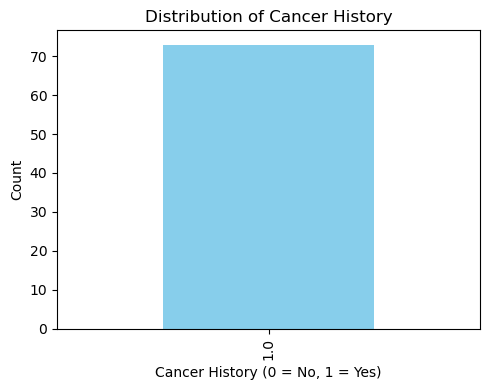

In [5]:
plt.figure(figsize=(5,4))
df['cancer_history'].value_counts().plot(kind='bar',color=['skyblue', 'salmon'])
plt.title('Distribution of Cancer History')
plt.xlabel('Cancer History (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 🩺 Interpretation:
Most patients (nearly 9 out of 10) have no prior cancer history, meaning the dataset is dominated by first-time cancer cases.

In [6]:
print("\nVital status value counts:\n", df['vital_status_12'].value_counts())
print("\nVital status percentage:\n", df['vital_status_12'].value_counts(normalize=True) * 100)


Vital status value counts:
 vital_status_12
1    543
0     75
Name: count, dtype: int64

Vital status percentage:
 vital_status_12
1    87.864078
0    12.135922
Name: proportion, dtype: float64


| Vital Status     | Count (%)  | Meaning                                       |
| ---------------- | ---------- | --------------------------------------------- |
| **1 (Alive)**    | **87.86%** | Patients who survived after 12 months         |
| **0 (Deceased)** | **12.14%** | Patients who did not survive within 12 months |

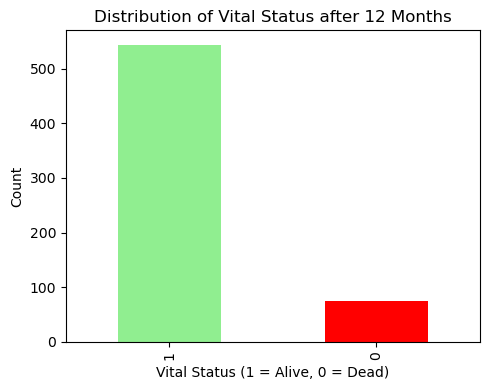

In [7]:
plt.figure(figsize=(5,4))
df['vital_status_12'].value_counts().plot(kind='bar',color=['lightgreen', 'red'])
plt.title('Distribution of Vital Status after 12 Months')
plt.xlabel('Vital Status (1 = Alive, 0 = Dead)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## ⚕️ Interpretation:
The dataset contains both alive and deceased patients, confirming it includes a mix of healthy and cancer-affected cases, suitable for survival prediction modeling.

## 4. Handle Missing Values

In [8]:
# NOTE: Originally cancer_history is mostly NaN
# We'll create a missingness flag first, then fill NaN as 0
if 'cancer_history' in df.columns:
    df['cancer_history_missing'] = df['cancer_history'].isna().astype(int)
    df['cancer_history'] = df['cancer_history'].fillna(0)

# Fill missing 'gender' with the mode (if any)
if 'gender' in df.columns and df['gender'].isnull().sum() > 0:
    df['gender'] = df['gender'].fillna(df['gender'].mode()[0])

# Fill missing 'age_diag' with median
if 'age_diag' in df.columns and df['age_diag'].isnull().sum() > 0:
    df['age_diag'] = df['age_diag'].fillna(df['age_diag'].median())

print("\nMissing values AFTER cleaning:\n", df.isnull().sum())


Missing values AFTER cleaning:
 case_id                           0
gender                            0
age_diag                          0
grade                             0
cancer_history                    0
ajcc_path_tumor_pt                0
ajcc_path_nodes_pn                0
ajcc_clin_metastasis_cm           0
ajcc_path_metastasis_pm           0
ajcc_path_tumor_stage             0
vital_status_12                   0
race_Asian                        0
race_Black or African American    0
race_Hispanic or Latino           0
race_White                        0
race_other                        0
VHL_mutation                      0
PBMR1_mutation                    0
TTN_mutation                      0
Split                             0
cancer_history_missing            0
dtype: int64


## Feature engineering

In [9]:
# ======================
# Feature Engineering
# ======================
# 4.1 Age binning
df['age_group'] = pd.cut(
    df['age_diag'],
    bins=[0, 40, 60, 80, 150],
    labels=[0, 1, 2, 3]
).astype(int)

# 4.2 High-risk tumor properties
df['high_grade'] = (df['grade'] >= 3).astype(int)
df['advanced_stage'] = (df['ajcc_path_tumor_stage'] >= 3).astype(int)
df['any_metastasis'] = (
    (df['ajcc_path_metastasis_pm'] > 0) |
    (df['ajcc_clin_metastasis_cm'] > 0)
).astype(int)
df['any_nodes'] = (df['ajcc_path_nodes_pn'] > 0).astype(int)

# 4.3 Mutation interaction features
df['VHL_PBMR1_both'] = (df['VHL_mutation'] & df['PBMR1_mutation']).astype(int)
df['any_mutation'] = (
    (df['VHL_mutation'] == 1) |
    (df['PBMR1_mutation'] == 1) |
    (df['TTN_mutation'] == 1)
).astype(int)

## 5. Separate Target First

In [10]:
y = df['vital_status_12']  # 0/1

feature_cols = [
    'gender', 'age_diag', 'grade', 'cancer_history',
    'ajcc_path_tumor_pt', 'ajcc_path_nodes_pn',
    'ajcc_clin_metastasis_cm', 'ajcc_path_metastasis_pm',
    'ajcc_path_tumor_stage',
    'race_Asian', 'race_Black or African American',
    'race_Hispanic or Latino', 'race_White', 'race_other',
    'VHL_mutation', 'PBMR1_mutation', 'TTN_mutation',

    # engineered:
    'cancer_history_missing', 'age_group',
    'high_grade', 'advanced_stage', 'any_metastasis', 'any_nodes',
    'VHL_PBMR1_both', 'any_mutation'
]

X = df[feature_cols]

print("\nFeature dtypes:\n", X.dtypes)
print("\nX shape:", X.shape, " y shape:", y.shape)


Feature dtypes:
 gender                              int64
age_diag                          float64
grade                               int64
cancer_history                    float64
ajcc_path_tumor_pt                  int64
ajcc_path_nodes_pn                  int64
ajcc_clin_metastasis_cm             int64
ajcc_path_metastasis_pm             int64
ajcc_path_tumor_stage               int64
race_Asian                          int64
race_Black or African American      int64
race_Hispanic or Latino             int64
race_White                          int64
race_other                          int64
VHL_mutation                        int64
PBMR1_mutation                      int64
TTN_mutation                        int64
cancer_history_missing              int64
age_group                           int64
high_grade                          int64
advanced_stage                      int64
any_metastasis                      int64
any_nodes                           int64
VHL_PBMR1_both  

In [11]:
# # Target: 1 = Alive, 0 = Dead
# # Target
# y = df['vital_status_12']

# # Drop target and non-numeric columns
# X = df.drop(columns=['vital_status_12', 'case_id', 'Split'])

# print(X.dtypes)

## 8. Train–Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTraining data size:", X_train.shape)
print("Testing data size:", X_test.shape)


Training data size: (494, 25)
Testing data size: (124, 25)


## 9. Feature Scaling (only numeric)

In [13]:
# STEP 1: SCALE TRAIN AND TEST
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)


Scaled shapes: (494, 25) (124, 25)


In [14]:
X_train_eval = X_train_scaled
X_test_eval  = X_test_scaled

## 10. Define Models (with Imbalance Handling)

In [15]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print(f"\nscale_pos_weight for XGBoost: {scale_pos_weight:.2f} (neg/pos = {neg}/{pos})")

trained_models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    ),
    "Random Forest": RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_estimators=200
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}


scale_pos_weight for XGBoost: 0.14 (neg/pos = 60/434)


## 11. Train & Evaluate Models

In [16]:
results = {}

for name, model in trained_models.items():
    print(f"\n================= {name} =================")
    model.fit(X_train_eval, y_train)

    # Predictions
    y_pred = model.predict(X_test_eval)

    # Probability of class 0 (Dead)
    y_prob = model.predict_proba(X_test_eval)[:, 0]

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # AUC for Dead (class 0): invert y_test because roc_auc_score assumes pos_class=1
    auc = roc_auc_score(1 - y_test, y_prob)

    # Other metrics
    cls_report = classification_report(y_test, y_pred, digits=4)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    results[name] = {
        "model": model,
        "Accuracy": acc,
        "ROC-AUC": auc,
        "Classification": classification_report(y_test, y_pred, output_dict=True),
        "Confusion": cm,
        "y_prob": y_prob
    }

    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC (Dead): {auc:.4f}")
    print("\nClassification Report:\n", cls_report)
    print("Confusion Matrix:\n", cm)





================= Logistic Regression =================
Accuracy: 0.7419
ROC-AUC (Dead): 0.7725

Classification Report:
               precision    recall  f1-score   support

           0     0.2927    0.8000    0.4286        15
           1     0.9639    0.7339    0.8333       109

    accuracy                         0.7419       124
   macro avg     0.6283    0.7670    0.6310       124
weighted avg     0.8827    0.7419    0.7844       124

Confusion Matrix:
 [[12  3]
 [29 80]]

================= Random Forest =================
Accuracy: 0.9194
ROC-AUC (Dead): 0.8780

Classification Report:
               precision    recall  f1-score   support

           0     0.7778    0.4667    0.5833        15
           1     0.9304    0.9817    0.9554       109

    accuracy                         0.9194       124
   macro avg     0.8541    0.7242    0.7693       124
weighted avg     0.9120    0.9194    0.9104       124

Confusion Matrix:
 [[  7   8]
 [  2 107]]

================= XGBoost =

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [14:41:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 12. Bar Charts: Recall & F1-score

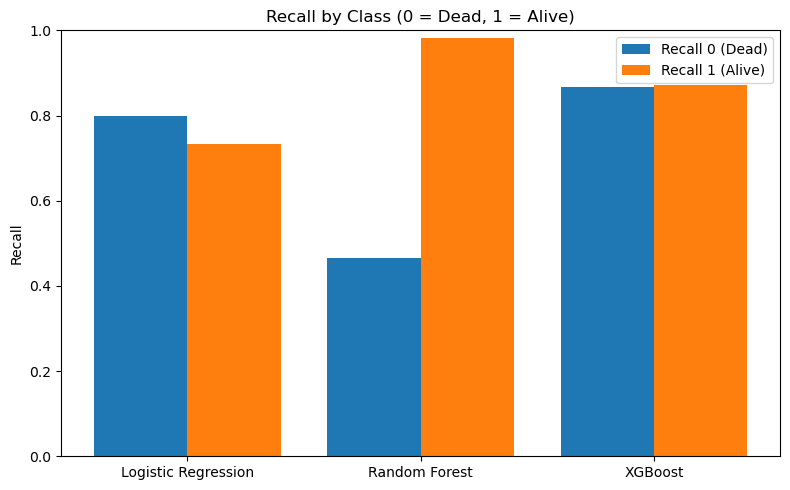

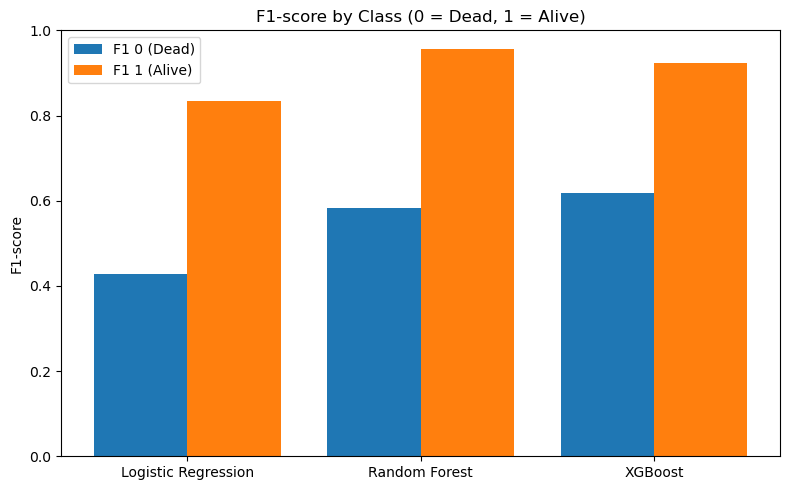

In [17]:
models_list = list(results.keys())

recall_dead  = [results[m]['Classification']['0']['recall']     for m in models_list]
recall_alive = [results[m]['Classification']['1']['recall']     for m in models_list]
f1_dead      = [results[m]['Classification']['0']['f1-score']   for m in models_list]
f1_alive     = [results[m]['Classification']['1']['f1-score']   for m in models_list]

x = np.arange(len(models_list))

plt.figure(figsize=(8,5))
plt.bar(x - 0.2, recall_dead,  width=0.4, label='Recall 0 (Dead)')
plt.bar(x + 0.2, recall_alive, width=0.4, label='Recall 1 (Alive)')
plt.xticks(x, models_list)
plt.ylabel("Recall")
plt.title("Recall by Class (0 = Dead, 1 = Alive)")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.bar(x - 0.2, f1_dead,  width=0.4, label='F1 0 (Dead)')
plt.bar(x + 0.2, f1_alive, width=0.4, label='F1 1 (Alive)')
plt.xticks(x, models_list)
plt.ylabel("F1-score")
plt.title("F1-score by Class (0 = Dead, 1 = Alive)")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


## 13. Confusion Matrix Heatmaps

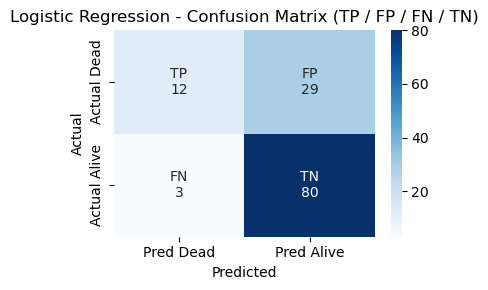

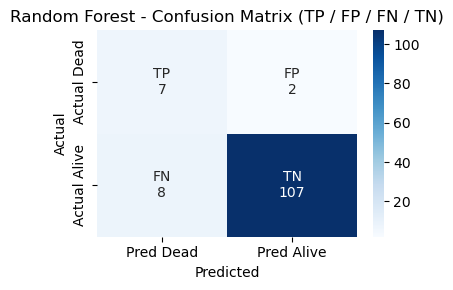

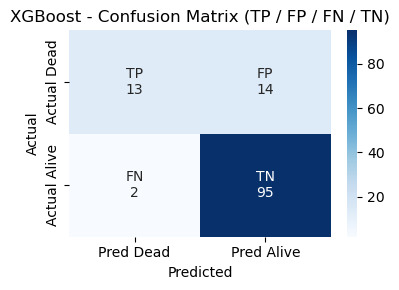

In [18]:
for m in models_list:
    cm = results[m]['Confusion']
    
    # Extract confusion matrix pieces
    TP = cm[0, 0]
    FN = cm[0, 1]
    FP = cm[1, 0]
    TN = cm[1, 1]
    
    # Custom order matrix
    custom_cm = np.array([
        [TP, FP],
        [FN, TN]
    ])
    
    labels = np.array([
        [f"TP\n{TP}", f"FP\n{FP}"],
        [f"FN\n{FN}", f"TN\n{TN}"]
    ])
    
    # Plot
    plt.figure(figsize=(4,3))
    sns.heatmap(
        custom_cm,
        annot=labels,
        fmt='',
        cmap='Blues',
        xticklabels=['Pred Dead', 'Pred Alive'],
        yticklabels=['Actual Dead', 'Actual Alive']
    )
    
    plt.title(f"{m} - Confusion Matrix (TP / FP / FN / TN)")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()



### Confusion Matrix Metrics (Dead = Positive Class)

**Accuracy**  
\\[
Accuracy = {TP + TN}/{TP + TN + FP + FN}
\\]

**Precision (Dead)**  
\\[
Precision = {TP}/{TP + FP}
\\]

**Recall (Dead)**  
\\[
Recall = {TP}/{TP + FN}
\\]

**F1 Score**  
\\[
F1 = {2PR}/{P + R}
\\]



| ------ | Logisitc Regression          | ----- |
| ------ | ---------------------------- | ----- |
| Term   | Meaning                      | Value |    
| **TP** | Actual Dead predicted Dead   | 12    |
| **FN** | Actual Dead predicted Alive  | 3     |
| **FP** | Actual Alive predicted Dead  | 29    |
| **TN** | Actual Alive predicted Alive | 80    |


| ------ | Random Forest                | ----- |
| ------ | ---------------------------- | ----- |
| Term   | Meaning               | Value | 
| **TP** | Dead predicted Dead   | 7     |
| **FN** | Dead predicted Alive  | 8     |
| **FP** | Alive predicted Dead  | 2     |
| **TN** | Alive predicted Alive | 107   |

| ------ | Random Forest                | ----- |
| ------ | ---------------------------- | ----- |
| Term   | Meaning               | Value |
| **TP** | Dead predicted Dead   | 13    |
| **FN** | Dead predicted Alive  | 2     |
| **FP** | Alive predicted Dead  | 16    |
| **TN** | Alive predicted Alive | 93    |





## 14. ROC Curves

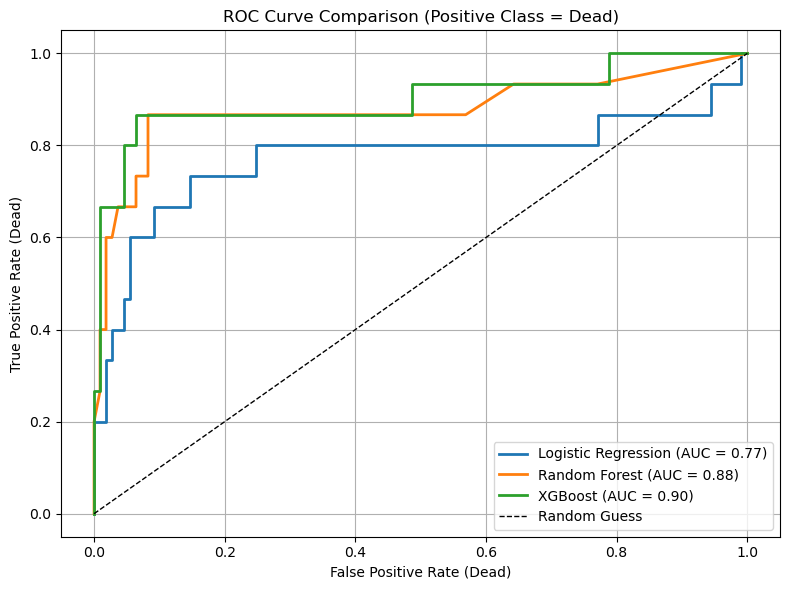

In [19]:
plt.figure(figsize=(8,6))

for m in models_list:
    y_prob = results[m]['y_prob']                        # P(Dead)
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=0) # Dead is positive
    auc = results[m]['ROC-AUC']
    plt.plot(fpr, tpr, lw=2, label=f"{m} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Guess')
plt.xlabel('False Positive Rate (Dead)')
plt.ylabel('True Positive Rate (Dead)')
plt.title('ROC Curve Comparison (Positive Class = Dead)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feed-Forward Neural Network (FFNN)

### 1. Class weights (on ORIGINAL y_train)

In [20]:
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: cw[0], 1: cw[1]}
print("Class Weights (0=Dead, 1=Alive):", class_weights)

Class Weights (0=Dead, 1=Alive): {0: 4.116666666666666, 1: 0.5691244239631337}


### 2. Oversample minority class (Dead = 0) on SCALED training data

In [21]:
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_scaled, y_train)

print("Before oversampling:", X_train_scaled.shape, np.bincount(y_train))
print("After oversampling :", X_train_res.shape, np.bincount(y_train_res))


Before oversampling: (494, 25) [ 60 434]
After oversampling : (868, 25) [434 434]


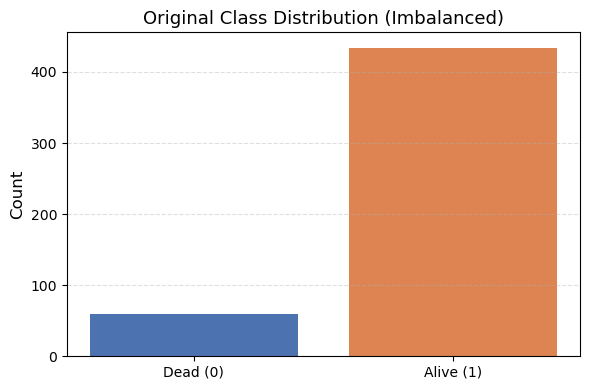

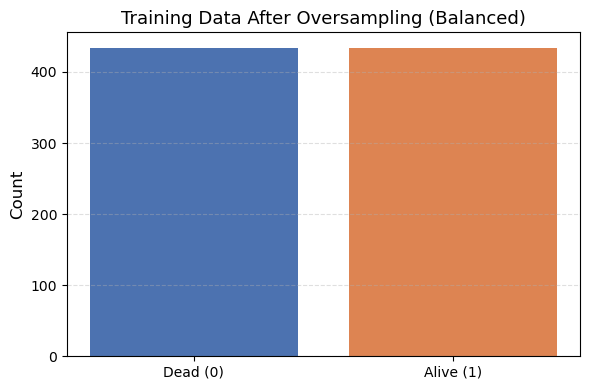

In [30]:

# ORIGINAL distribution (from your output)
original_counts = np.array([60, 434])   # [Dead, Alive]

# AFTER OVERSAMPLING (from your output)
oversampled_counts = np.array([434, 434])

# Labels
classes = ['Dead (0)', 'Alive (1)']

# Professional colors
color_dead = '#4C72B0'     # muted teal
color_alive = '#DD8452'    # soft orange

# ------------------------------
# 1. Original Imbalanced Dataset
# ------------------------------
plt.figure(figsize=(6,4))
plt.bar(classes, original_counts, color=[color_dead, color_alive])
plt.title("Original Class Distribution (Imbalanced)", fontsize=13)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# ------------------------------
# 2. After Oversampling (Balanced)
# ------------------------------
plt.figure(figsize=(6,4))
plt.bar(classes, oversampled_counts, color=[color_dead, color_alive])
plt.title("Training Data After Oversampling (Balanced)", fontsize=13)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### 3. Train / validation split on RESAMPLED data

In [22]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_res, y_train_res,
    test_size=0.2,
    random_state=42,
    stratify=y_train_res
)

print("Train shape:", X_tr.shape, " Val shape:", X_val.shape)
print("y_tr distribution:", np.bincount(y_tr))
print("y_val distribution:", np.bincount(y_val))


Train shape: (694, 25)  Val shape: (174, 25)
y_tr distribution: [347 347]
y_val distribution: [87 87]


### 4. Define Improved Neural Network

In [23]:
nn_model2 = Sequential([
    Dense(256, activation='relu', input_shape=(X_tr.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')   # output = P(Dead=0)
])

nn_model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 5. Train NN with oversampled train + separate validation

In [24]:
history2 = nn_model2.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    class_weight=class_weights,   # handles original imbalance
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4813 - loss: 1.4093 - val_accuracy: 0.5000 - val_loss: 0.8159
Epoch 2/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 0.8162 - val_accuracy: 0.5000 - val_loss: 1.0283
Epoch 3/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 0.7824 - val_accuracy: 0.5000 - val_loss: 0.9203
Epoch 4/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 0.7488 - val_accuracy: 0.5000 - val_loss: 0.8509
Epoch 5/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 0.7114 - val_accuracy: 0.5000 - val_loss: 0.7927
Epoch 6/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5014 - loss: 0.6961 - val_accuracy: 0.5000 - val_loss: 0.8005
Epoch 7/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5058 - loss: 0.6577 - val_accuracy: 0.5230 - val_loss: 0.7340
Epoch 8/80
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5187 - loss: 0.6428 - val_accuracy: 0.5805 - val_loss:

### 6. Evaluate on TEST set (scaled)

#### P(Dead)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Improved NN Classification Report (threshold=0.4):

              precision    recall  f1-score   support

           0     0.5000    0.8000    0.6154        15
           1     0.9700    0.8899    0.9282       109

    accuracy                         0.8790       124
   macro avg     0.7350    0.8450    0.7718       124
weighted avg     0.9131    0.8790    0.8904       124

Improved NN AUC (Dead): 0.12844036697247702

Improved NN Confusion Matrix:
 [[12  3]
 [12 97]]


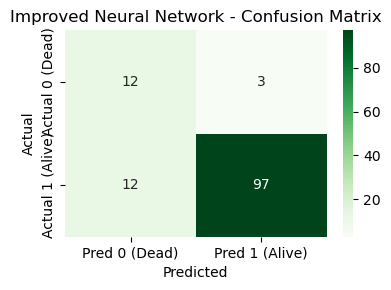

In [25]:
y_prob_nn2 = nn_model2.predict(X_test_scaled).ravel()

# threshold for class 0 (Dead) – tune if needed
threshold = 0.40
y_pred_nn2 = (y_prob_nn2 >= threshold).astype(int)

print(f"\nImproved NN Classification Report (threshold={threshold}):\n")
print(classification_report(y_test, y_pred_nn2, digits=4))

# AUC for Dead (class 0) – invert y_test because roc_auc_score assumes pos=1
auc_nn2 = roc_auc_score(1 - y_test, y_prob_nn2)
print("Improved NN AUC (Dead):", auc_nn2)

cm_nn2 = confusion_matrix(y_test, y_pred_nn2, labels=[0, 1])
print("\nImproved NN Confusion Matrix:\n", cm_nn2)

# Confusion matrix heatmap
plt.figure(figsize=(4,3))
sns.heatmap(
    cm_nn2,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Pred 0 (Dead)', 'Pred 1 (Alive)'],
    yticklabels=['Actual 0 (Dead)', 'Actual 1 (Alive)']
)
plt.title("Improved Neural Network - Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


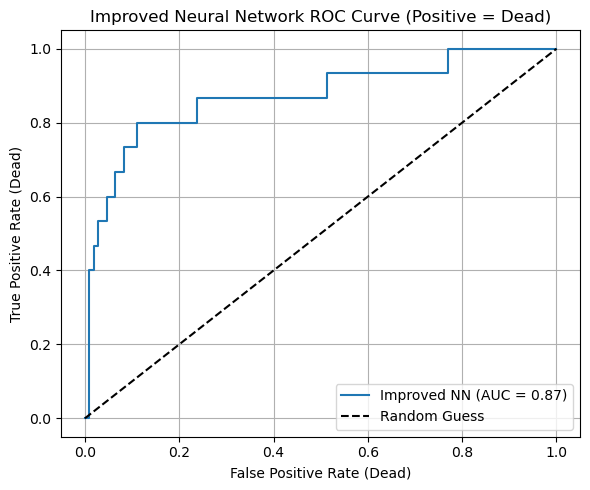

In [26]:
# NN gives P(Alive). We need P(Dead)
y_prob_dead = 1 - y_prob_nn2

fpr_nn2, tpr_nn2, _ = roc_curve(y_test, y_prob_dead, pos_label=0)
auc_nn2 = roc_auc_score(1 - y_test, y_prob_dead)

plt.figure(figsize=(6,5))
plt.plot(fpr_nn2, tpr_nn2, label=f"Improved NN (AUC = {auc_nn2:.2f})")
plt.plot([0,1],[0,1],'k--', label='Random Guess')
plt.xlabel("False Positive Rate (Dead)")
plt.ylabel("True Positive Rate (Dead)")
plt.title("Improved Neural Network ROC Curve (Positive = Dead)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


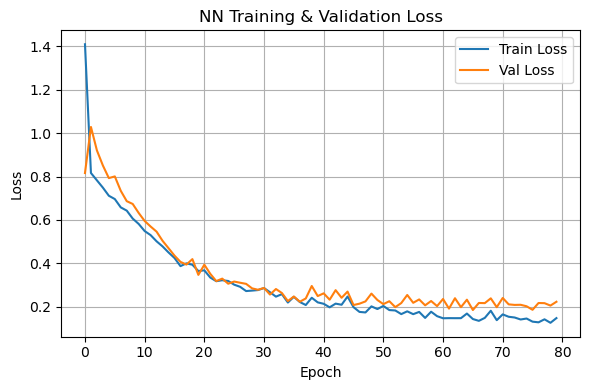

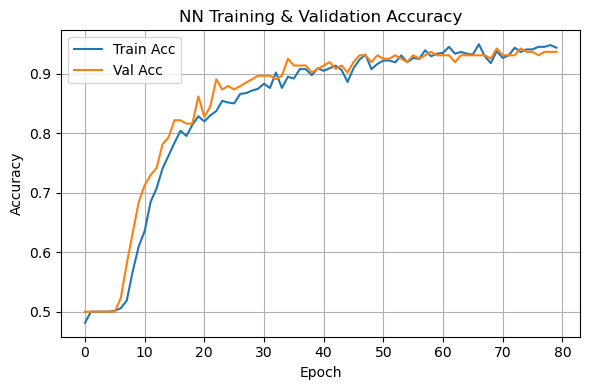

In [27]:
# Training & validation curves (for report / validation loss discussion)
plt.figure(figsize=(6,4))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NN Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('NN Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()